# 🧠 Smart Loan Approval & Fraud Detection System
This project predicts loan approval and detects potential fraud using loan application data and customer transaction history.

### ✨ Objectives:
- Predict whether a loan will be approved
- Identify fraudulent applications
- Explain decisions using SHAP

In [156]:
#IMPORTING PACKAGES
 
# Data manipulation & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Explainability
import shap

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Display settings
pd.set_option('display.max_columns', None)

In [157]:
# Loading loan applications data
loan_df = pd.read_csv('../data/loan_applications.csv')

# Preview both datasets
print("Loan Applications Data:")
display(loan_df.head(3))

# Loading transaction data
txn_df=pd.read_csv('../data/transactions.csv')

print("\nTransaction Data:")
display(txn_df.head(3))

Loan Applications Data:


,application_id,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,gender,number_of_dependents,loan_status,fraud_flag,fraud_type
0,c8bf0bea-70e6-4870-9125-41b8210c527f,CUST109427,2023-04-09,Business Loan,604000.0,12,11.66,Medical Emergency,Retired,34700.0,714,1100.0,3.17,Rented,"94/31, Sehgal Zila, Vadodara-380521, Anantapur...",28,Female,3,Approved,0,NaN
1,91224cec-3544-4bc7-ac15-a9792da54c02,CUST106146,2023-09-23,Car Loan,100000.0,240,13.62,Education,Unemployed,51600.0,667,0.0,0.00,Owned,"H.No. 00, Sheth Chowk, Ichalkaranji 006728, Im...",44,Other,3,Approved,0,NaN
2,4efcd02d-4a03-4ab7-9bd1-0ff430493d0c,CUST100674,2023-05-22,Education Loan,431000.0,60,11.40,Medical Emergency,Self-Employed,14800.0,808,4600.0,31.08,Rented,"H.No. 81, Dutta Path, Kozhikode-340301, Tadepa...",56,Other,4,Approved,0,NaN



Transaction Data:


,transaction_id,customer_id,transaction_date,transaction_type,transaction_amount,merchant_category,merchant_name,transaction_location,account_balance_after_transaction,is_international_transaction,device_used,ip_address,transaction_status,transaction_source_destination,transaction_notes,fraud_flag
0,2d7ddfd4-1112-4354-a2dd-fad94b45a850,CUST102188,2022-01-04 11:27:00,Bill Payment,2100.0,Dining,"Rattan, Khanna and Magar","Srikakulam, Himachal Pradesh",8211.0,0,Web,31.102.21.141,Success,BCHG80012468703731,Payment for Dining,0
1,ba998721-a612-4e0a-8354-46d001e9c39c,CUST107144,2022-01-03 23:52:00,UPI,1400.0,Travel,Chauhan LLC,"Giridih, Manipur",12858.0,0,Web,176.48.222.166,Success,CJPZ11841095072972,Payment for Travel,0
2,0b4ad8e2-40ac-49c9-b59a-c9efaaccc7a6,CUST102126,2022-01-15 06:54:00,Debit Card,1000.0,Entertainment,Halder-Sarma,"Avadi, Kerala",19268.0,0,ATM,181.62.105.161,Success,TLCG50761416960179,Payment for Entertainment,0


In [158]:
# Shape and data types
print("Shape of loan application data:", loan_df.shape)
loan_df.info()

Shape of loan application data: (50000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   application_id             50000 non-null  object 
 1   customer_id                50000 non-null  object 
 2   application_date           50000 non-null  object 
 3   loan_type                  50000 non-null  object 
 4   loan_amount_requested      50000 non-null  float64
 5   loan_tenure_months         50000 non-null  int64  
 6   interest_rate_offered      50000 non-null  float64
 7   purpose_of_loan            50000 non-null  object 
 8   employment_status          50000 non-null  object 
 9   monthly_income             50000 non-null  float64
 10  cibil_score                50000 non-null  int64  
 11  existing_emis_monthly      50000 non-null  float64
 12  debt_to_income_ratio       50000 non-null  float64
 13  pr

In [159]:
print("Shape of Transaction data:", txn_df.shape)
txn_df.info()

Shape of Transaction data: (50000, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   transaction_id                     50000 non-null  object 
 1   customer_id                        50000 non-null  object 
 2   transaction_date                   50000 non-null  object 
 3   transaction_type                   50000 non-null  object 
 4   transaction_amount                 50000 non-null  float64
 5   merchant_category                  50000 non-null  object 
 6   merchant_name                      50000 non-null  object 
 7   transaction_location               50000 non-null  object 
 8   account_balance_after_transaction  50000 non-null  float64
 9   is_international_transaction       50000 non-null  int64  
 10  device_used                        50000 non-null  object 
 11  ip_address     

In [160]:
# Check missing values
print("\nMissing values in loan application data:")
loan_df.isnull().sum()


Missing values in loan application data:


application_id                   0
customer_id                      0
application_date                 0
loan_type                        0
loan_amount_requested            0
loan_tenure_months               0
interest_rate_offered            0
purpose_of_loan                  0
employment_status                0
monthly_income                   0
cibil_score                      0
existing_emis_monthly            0
debt_to_income_ratio             0
property_ownership_status        0
residential_address              0
applicant_age                    0
gender                           0
number_of_dependents             0
loan_status                      0
fraud_flag                       0
fraud_type                   48974
dtype: int64

In [161]:
# Check for missing values
print("\nMissing values transaction data:")
txn_df.isnull().sum()


Missing values transaction data:


transaction_id                       0
customer_id                          0
transaction_date                     0
transaction_type                     0
transaction_amount                   0
merchant_category                    0
merchant_name                        0
transaction_location                 0
account_balance_after_transaction    0
is_international_transaction         0
device_used                          0
ip_address                           0
transaction_status                   0
transaction_source_destination       0
transaction_notes                    0
fraud_flag                           0
dtype: int64

EDA

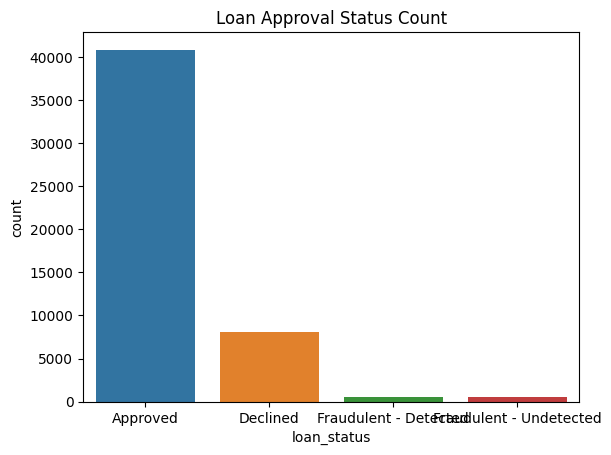

In [162]:
# Loan Status Distribution
sns.countplot(x='loan_status', data=loan_df)
plt.title("Loan Approval Status Count")
plt.show()

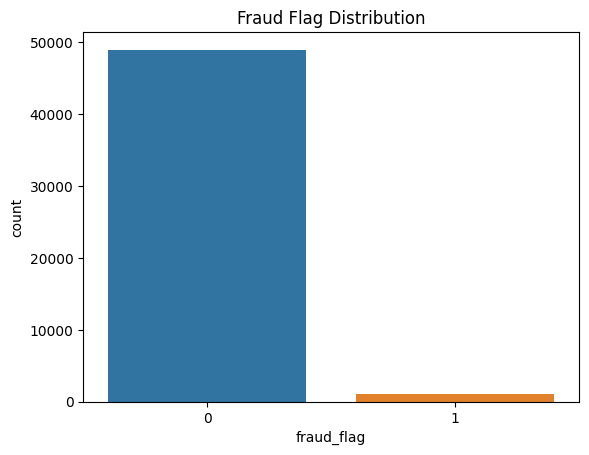

In [163]:
# Fraud Flag Distribution
sns.countplot(x='fraud_flag', data=loan_df)
plt.title("Fraud Flag Distribution")
plt.show()

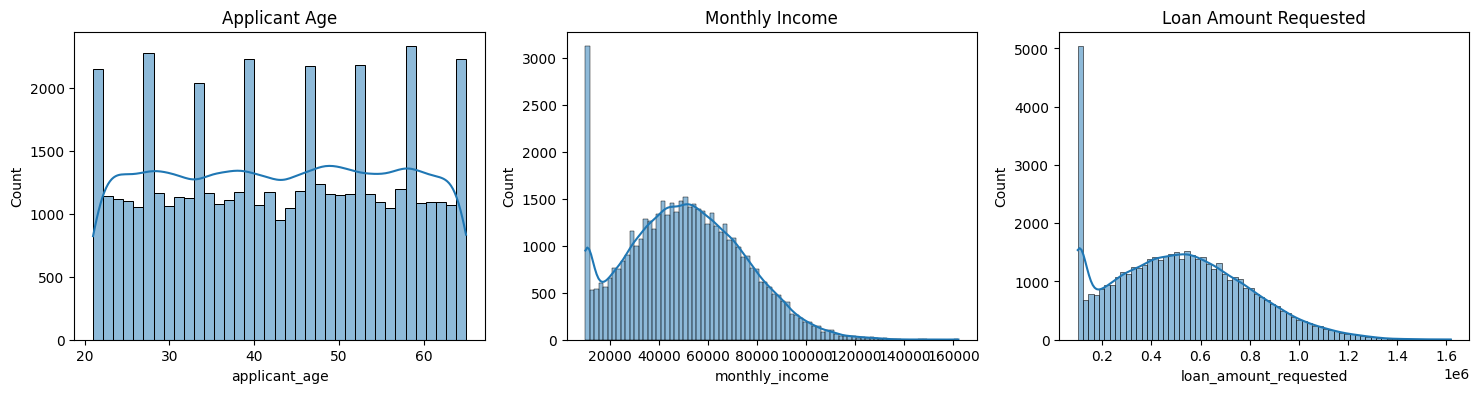

In [164]:
# Age, Income, Loan Amount
loan_df[['applicant_age', 'monthly_income', 'loan_amount_requested']].describe()

# Distribution Plots
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(loan_df['applicant_age'], kde=True, ax=axs[0])
sns.histplot(loan_df['monthly_income'], kde=True, ax=axs[1])
sns.histplot(loan_df['loan_amount_requested'], kde=True, ax=axs[2])
axs[0].set_title("Applicant Age")
axs[1].set_title("Monthly Income")
axs[2].set_title("Loan Amount Requested")
plt.show()


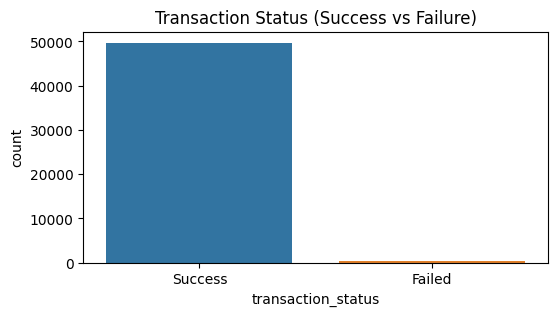

In [165]:
plt.figure(figsize=(6, 3))
sns.countplot(x='transaction_status', data=txn_df)
plt.title("Transaction Status (Success vs Failure)")
plt.show()


##### FEATURE ENGINEERING

In [166]:
# Convert transaction_date to datetime
txn_df['transaction_date'] = pd.to_datetime(txn_df['transaction_date'], dayfirst=True)

# Feature engineering - summarize transaction behavior per customer
txn_summary = txn_df.groupby('customer_id').agg({
    'transaction_amount': ['mean', 'sum', 'count'],
    'transaction_type': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'device_used': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'transaction_status': lambda x: (x != 'Success').mean(),
    'is_international_transaction': 'sum'
}).reset_index()

# Rename columns for clarity
txn_summary.columns = ['customer_id', 'avg_txn_amount', 'total_txn_amount', 'txn_count',
                       'most_common_txn_type', 'most_used_device', 'failed_txn_ratio', 'intl_txn_count']

# Preview
txn_summary.head()


,customer_id,avg_txn_amount,total_txn_amount,txn_count,most_common_txn_type,most_used_device,failed_txn_ratio,intl_txn_count
0,CUST100000,1350.000000,2700.0,2,Credit Card,Mobile,0.0,0
1,CUST100001,7733.333333,23200.0,3,Debit Card,ATM,0.0,0
2,CUST100003,4400.000000,13200.0,3,Credit Card,POS,0.0,0
3,CUST100005,7350.000000,14700.0,2,Debit Card,Mobile,0.0,0
4,CUST100006,2533.333333,7600.0,3,UPI,Mobile,0.0,0


MERGED DATASET

Merge Transaction Features with Loan Applications based on customer_id

In [167]:
# Merge txn_summary into loan_df using customer_id
loan_merged = pd.merge(loan_df, txn_summary, on='customer_id', how='left')

# Show merged result
print("Merged Data Shape:", loan_merged.shape)
loan_merged.head(3)


Merged Data Shape: (50000, 28)


,application_id,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,gender,number_of_dependents,loan_status,fraud_flag,fraud_type,avg_txn_amount,total_txn_amount,txn_count,most_common_txn_type,most_used_device,failed_txn_ratio,intl_txn_count
0,c8bf0bea-70e6-4870-9125-41b8210c527f,CUST109427,2023-04-09,Business Loan,604000.0,12,11.66,Medical Emergency,Retired,34700.0,714,1100.0,3.17,Rented,"94/31, Sehgal Zila, Vadodara-380521, Anantapur...",28,Female,3,Approved,0,NaN,6850.0,13700.0,2.0,ATM Withdrawal,ATM,0.0,0.0
1,91224cec-3544-4bc7-ac15-a9792da54c02,CUST106146,2023-09-23,Car Loan,100000.0,240,13.62,Education,Unemployed,51600.0,667,0.0,0.00,Owned,"H.No. 00, Sheth Chowk, Ichalkaranji 006728, Im...",44,Other,3,Approved,0,NaN,4675.0,18700.0,4.0,ATM Withdrawal,ATM,0.0,0.0
2,4efcd02d-4a03-4ab7-9bd1-0ff430493d0c,CUST100674,2023-05-22,Education Loan,431000.0,60,11.40,Medical Emergency,Self-Employed,14800.0,808,4600.0,31.08,Rented,"H.No. 81, Dutta Path, Kozhikode-340301, Tadepa...",56,Other,4,Approved,0,NaN,3275.0,13100.0,4.0,EMI Payment,Web,0.0,0.0


EDA AND PREPROCESS

In [168]:
# Copy to avoid changing original
df = loan_merged.copy()

In [169]:
# Handle missing values

# Fill numerical txn columns with 0 (e.g., no transactions)
txn_cols = ['avg_txn_amount', 'total_txn_amount', 'txn_count', 'failed_txn_ratio', 'intl_txn_count']
df[txn_cols] = df[txn_cols].fillna(0)

# Fill categorical with "Unknown"
df['most_common_txn_type'] = df['most_common_txn_type'].fillna("Unknown")
df['most_used_device'] = df['most_used_device'].fillna("Unknown")

In [170]:
# Encode categorical columns
cat_cols = ['loan_type', 'purpose_of_loan', 'employment_status', 'property_ownership_status',
            'gender', 'most_common_txn_type', 'most_used_device']

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

In [171]:
# Drop unused columns (IDs, text-heavy, address)
drop_cols = ['application_id', 'customer_id', 'application_date', 'residential_address', 'fraud_type', 'transaction_notes']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

In [172]:
# Convert target labels
df['loan_status_binary'] = df['loan_status'].map({
    'Approved': 0,  # or 1 if you prefer — just be consistent
    'Declined': 1,
    'Fraudulent - Detected': 1,
    'Fraudulent - Undetected': 1
})

df['fraud_flag'] = df['fraud_flag'].astype(int)

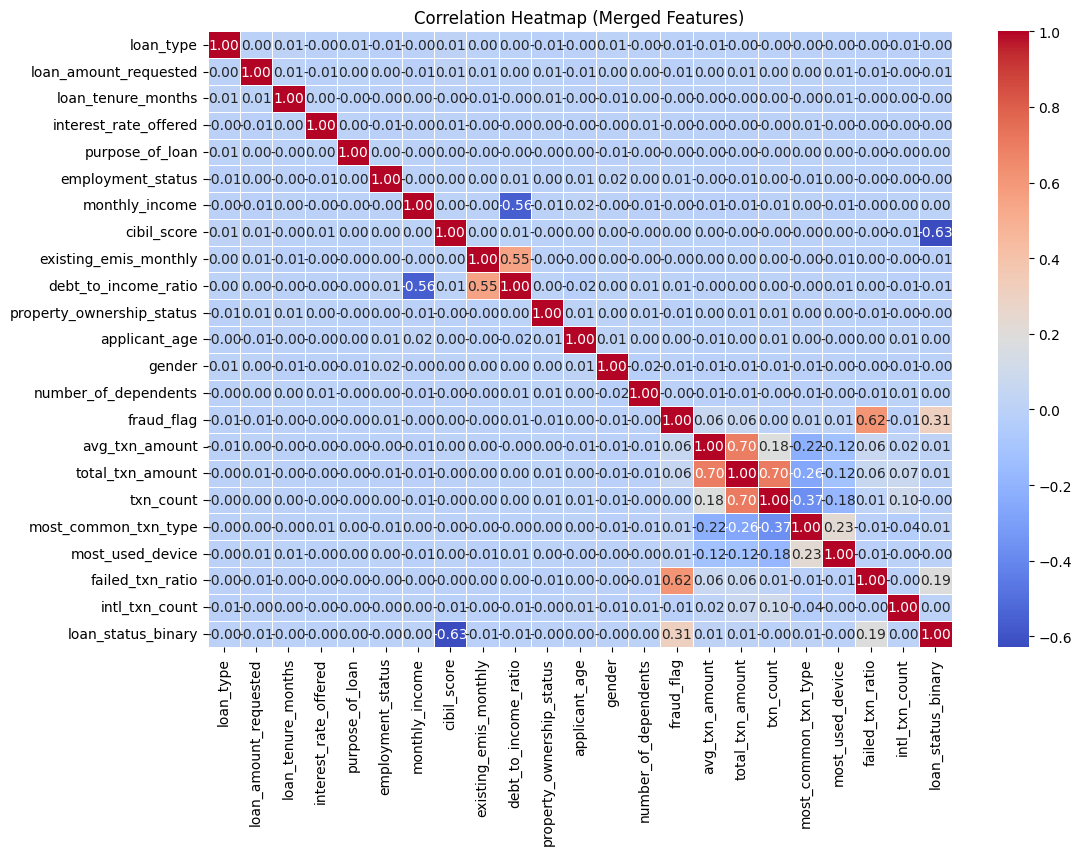

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt
numeric_cols = df.select_dtypes(include='number')
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Merged Features)")
plt.show()


In [174]:
from sklearn.model_selection import train_test_split
# Replace loan_status with binary labels
df['loan_status_binary'] = df['loan_status'].replace({
    'Approved': 0,
    'Declined': 1,
    'Fraudulent - Detected': 1,
    'Fraudulent - Undetected': 1
})

# Drop rows where loan_status_binary is still NaN
df = df.dropna(subset=['loan_status_binary'])

X = df.drop(['loan_status', 'fraud_flag', 'loan_status_binary'], axis=1)
y = df['loan_status_binary']

# Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [175]:
print(y.value_counts())
print(y.isnull().sum())  # Should be 0


0    40882
1     9118
Name: loan_status_binary, dtype: int64
0


In [176]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Separate numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


Build preprocessing pipeline

In [177]:
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000))
])

In [178]:
clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amount_requested',
                                                   'loan_tenure_months',
                                                   'interest_rate_offered',
                                                   'monthly_income',
                                                   'cibil_score',
                                                   'existing_emis_monthly',
                                                   'debt_to_income_ratio',
                                                   'applicant_age',
                                                   'number_of_dependents',
                                                   'avg_txn_amount',
                                                   'total_txn_amount',
                                                   'txn_count',
                                                   'failed_txn_ratio',
                                                   'intl_txn_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [179]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf_pipeline.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      8176
           1       1.00      0.93      0.96      1824

    accuracy                           0.99     10000
   macro avg       0.99      0.97      0.98     10000
weighted avg       0.99      0.99      0.99     10000

Confusion Matrix:
 [[8169    7]
 [ 122 1702]]


In [180]:
import joblib
joblib.dump(clf_pipeline, '../models/loan_classifier_binary.pkl')


['../models/loan_classifier_binary.pkl']

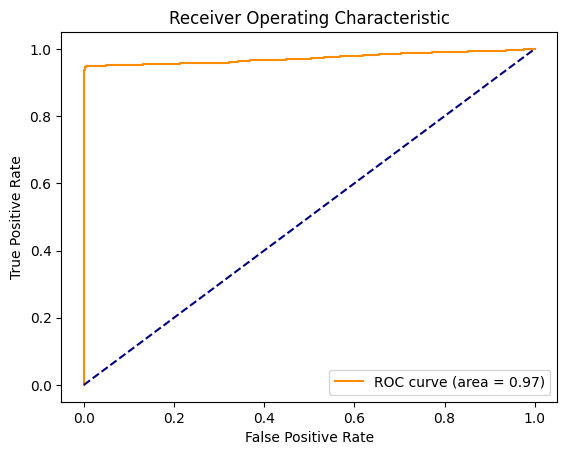

In [181]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_probs = clf_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()


✅ Interpretation of the ROC Curve:
🔶 AUC = 0.97
This means your model distinguishes between the positive and negative classes 97% of the time, which is very strong performance.
Closer to 1 = better.

🔶 Curve shape:
The orange curve hugs the top-left corner, meaning:
True Positive Rate (TPR) is high (correctly identifying approved loans).
False Positive Rate (FPR) is low (few rejected loans misclassified as approved).
The dashed diagonal line represents random guessing (AUC = 0.5). Your model clearly performs far better.

In [182]:
# Get feature names after transformation
feature_names = clf_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get coefficients from the logistic regression model
coef = clf_pipeline.named_steps['classifier'].coef_[0]

# Create DataFrame to show feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coef
}).sort_values(by='Importance', key=abs, ascending=False)

# Display top 10 important features
print(importance_df.head(10))


                       Feature  Importance
4             num__cibil_score   -5.862968
12       num__failed_txn_ratio    5.217072
11              num__txn_count   -0.086691
5   num__existing_emis_monthly   -0.065508
6    num__debt_to_income_ratio    0.046288
9          num__avg_txn_amount    0.033156
13         num__intl_txn_count   -0.021233
3          num__monthly_income    0.020938
7           num__applicant_age   -0.016013
0   num__loan_amount_requested   -0.012400


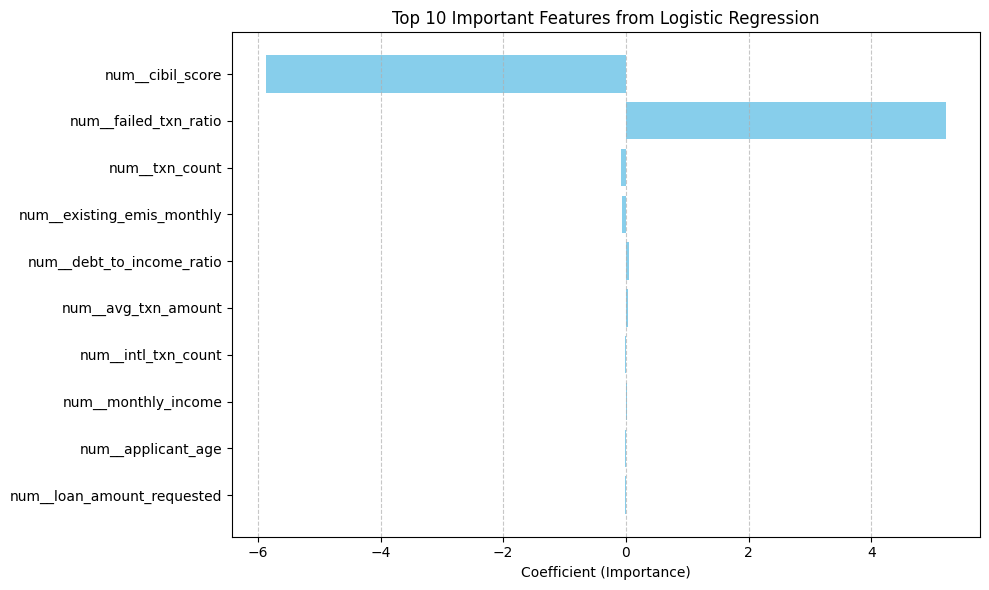

In [183]:
import matplotlib.pyplot as plt

# Plot top 10 features
top_n = 10
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel("Coefficient (Importance)")
plt.title(f"Top {top_n} Important Features from Logistic Regression")
plt.gca().invert_yaxis()  # Highest on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


XGBOOST

In [184]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        scale_pos_weight=4.5,  # imbalance: 40882/9118
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

clf_pipeline.fit(X_train, y_train)

y_pred = clf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8176
           1       1.00      0.95      0.97      1824

    accuracy                           0.99     10000
   macro avg       0.99      0.97      0.98     10000
weighted avg       0.99      0.99      0.99     10000

[[8176    0]
 [  95 1729]]


In [185]:
from sklearn.metrics import  roc_auc_score

y_pred = clf_pipeline.predict(X_test)
y_prob = clf_pipeline.predict_proba(X_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


ROC AUC Score: 0.9893713709573593


In [186]:
def predict_loan(input_data):
    """
    input_data: dict or DataFrame with same features as training set
    returns: prediction and probability
    """
    import pandas as pd
    df = pd.DataFrame([input_data])
    model = joblib.load("loan_approval_model.pkl")
    prediction = model.predict(df)[0]
    probability = model.predict_proba(df)[0][1]
    return prediction, probability


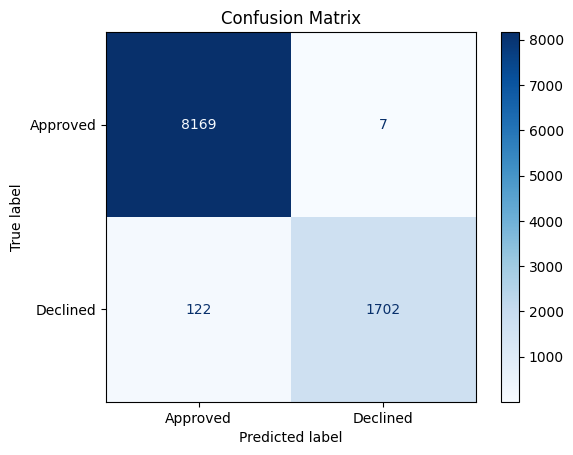

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      8176
           1       1.00      0.93      0.96      1824

    accuracy                           0.99     10000
   macro avg       0.99      0.97      0.98     10000
weighted avg       0.99      0.99      0.99     10000

ROC AUC Score: 0.9731186645981393

🔥 Misclassified Examples:
       loan_type  loan_amount_requested  loan_tenure_months  \
18369          2               100000.0                  24   
20428          4               637000.0                 240   
12969          1               552000.0                  60   
24411          0               579000.0                 120   
29811          0               538000.0                  36   

       interest_rate_offered  purpose_of_loan  employment_status  \
18369                  12.40                5                  4   
20428                   9.62                2                  3   
12969

In [187]:
# 🔍 MISCLASSIFICATION ANALYSIS
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# 1. Load your model and the same data used for training/testing
import joblib
model = joblib.load("loan_classifier_binary.pkl")

# Assuming you already have df from earlier in your script
# Remove any unused columns again just to be safe
X = df.drop(['loan_status', 'loan_status_binary', 'fraud_flag'], axis=1)
y = df['loan_status_binary']

# 2. Split test/train again to match model's logic (use same seed)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Predictions
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Approved', 'Declined'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 5. Classification Report + ROC AUC
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_probs))

# 6. View misclassified rows
misclassified = X_test[y_pred != y_test]
actual_wrong = y_test[y_pred != y_test]
pred_wrong = y_pred[y_pred != y_test]

print("\n🔥 Misclassified Examples:")
print(misclassified.head())
print("Actual:", actual_wrong.values[:5])
print("Predicted:", pred_wrong[:5])



SHAP Explanation for 1st Misclassified Case:


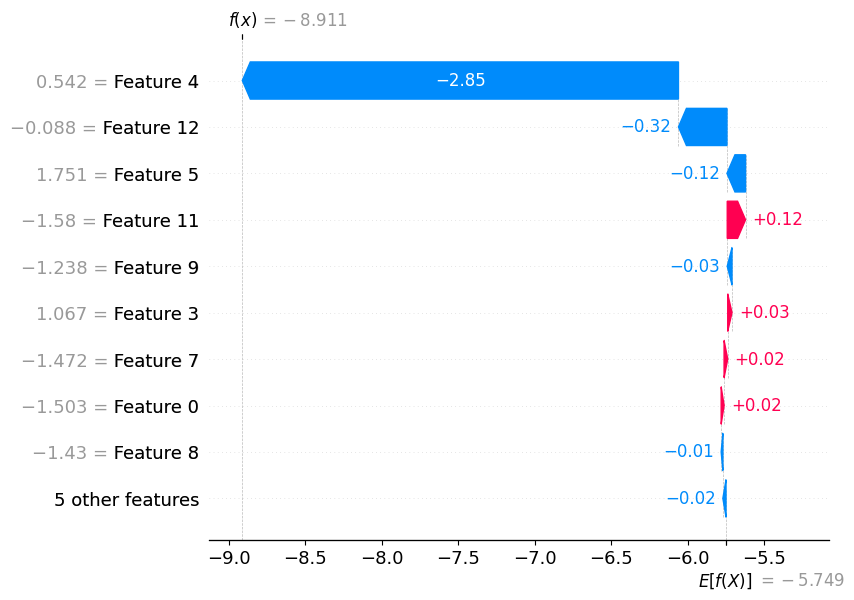

In [188]:
# 1. Extract classifier and preprocessor
pipeline = model
preprocessor = pipeline.named_steps['preprocessor']
classifier = pipeline.named_steps['classifier']

# 2. Transform test set with preprocessor
X_test_transformed = preprocessor.transform(X_test)

# 3. Use SHAP LinearExplainer for Logistic Regression
explainer = shap.Explainer(classifier, X_test_transformed)

# 4. Get SHAP values
shap_values = explainer(X_test_transformed)

# 5. Pick a misclassified row and explain
index = misclassified.index[0]
row_idx = list(X_test.index).index(index)

print("\nSHAP Explanation for 1st Misclassified Case:")
shap.plots.waterfall(shap_values[row_idx])
